In [10]:
import cv2
import json
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO
from collections import deque
import os

# Paths and Settings
OUTPUT_DIR = 'output'
ANNOTATED_DIR = os.path.join(OUTPUT_DIR, 'annotated_frames')
os.makedirs(ANNOTATED_DIR, exist_ok=True)
VIDEO_PATH = 'input_video.mp4'  # Replace with your video path
ALERT_LOG_PATH = 'output/alerts.json'
DETECTION_MODEL = YOLO('yolov5s.pt')


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0
consecutive_people = deque(maxlen=5)
alerts = []
people_spike_count = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 3 == 0:
        results = DETECTION_MODEL(frame)[0]
        person_count = 0

        for r in results.boxes.data.tolist():
            cls_id = int(r[5])
            if DETECTION_MODEL.names[cls_id] == "person":
                person_count += 1
            

        consecutive_people.append(person_count)
        people_spike_count.append(person_count)

        if len(consecutive_people) == 5 and all(p >= 3 for p in consecutive_people):
            alert_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            alerts.append({'frame': frame_count, 'alert': 'Crowd Detected', 'time': alert_time})
            
            print(f"[ALERT] Crowd Detected at frame {frame_count}")
            annotated_frame = results.plot()
            cv2.imwrite(f"{ANNOTATED_DIR}/frame_{frame_count}.jpg", annotated_frame)

    frame_count += 1
        

cap.release()

# Save alerts to file
with open(ALERT_LOG_PATH, 'w') as f:
    json.dump(alerts, f, indent=2)


0: 384x640 4 persons, 9 cars, 1 bus, 1 truck, 5 traffic lights, 115.1ms
Speed: 2.4ms preprocess, 115.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 10 cars, 1 bus, 1 truck, 4 traffic lights, 96.0ms
Speed: 1.1ms preprocess, 96.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 9 cars, 1 bus, 1 truck, 4 traffic lights, 89.5ms
Speed: 0.9ms preprocess, 89.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 10 cars, 1 bus, 2 trucks, 3 traffic lights, 106.9ms
Speed: 0.9ms preprocess, 106.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 9 cars, 1 bus, 3 trucks, 5 traffic lights, 89.9ms
Speed: 0.9ms preprocess, 89.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
[ALERT] Crowd Detected at frame 12

0: 384x640 4 persons, 8 cars, 1 bus, 2 trucks, 5 traffic lights, 96.5ms
Speed: 1.0ms preprocess, 96.5ms inferen

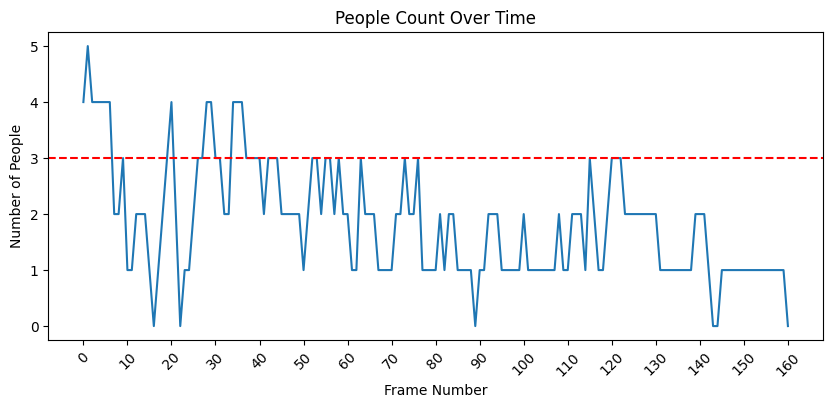

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(people_spike_count)
plt.axhline(y=3, color='r', linestyle='--', label='Alert Threshold (3 People)')
plt.xticks(range(0, len(people_spike_count), 10), rotation=45)
# plt.grid()
plt.title('People Count Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Number of People')
plt.savefig(os.path.join(OUTPUT_DIR, 'people_count_plot.png'))
plt.show()

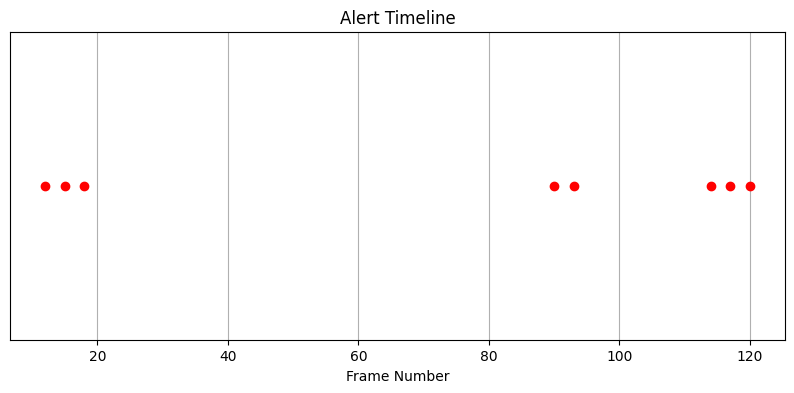

In [13]:
if alerts:
    alert_frames = [a['frame'] for a in alerts]
    alert_times = [a['time'] for a in alerts]

    plt.figure(figsize=(10, 4))
    plt.plot(alert_frames, [1]*len(alerts), 'ro', label='Alert Triggered')
    plt.yticks([])
    plt.xlabel("Frame Number")
    plt.title("Alert Timeline")
    plt.grid(True)
    plt.savefig('output/alert_timeline.png')
    plt.show()
else:
    print("No alerts triggered.")